# Two-qubit CZ gate behavior - Qutip implementation

In [21]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

from basic_units import radians, degrees, cos

col = ['C0','C1','C2','C3']

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

/Users/alicepagano/anaconda3/envs/qi/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  if sys.path[0] == '':


## Perfect blockade regime

### Functions definition

In [22]:
# Function for phase computation
def phase_func(z):
    # a + ib
    a = np.real(z)
    b = np.imag(z)
    
    if b==0:
        ph = 2*np.pi
    if (a>=0 and b>0): # I
        ph = np.arctan(b/a) 
    if (a<0 and b>0): # II
        ph = np.arctan(b/a) + np.pi
    if (a<0 and b<0): # III
        ph = np.arctan(b/a) + np.pi
    if (a>0 and b<0): # IV
        ph = 2*np.pi + np.arctan(b/a)
        
    return ph

In [133]:
# Definition of the Hamiltonian for a two-qubit CZ gate
def hamiltonian(Omega,Delta):
    
    psi00 = tensor(basis(3,0),basis(3,0))
    psi01 = tensor(basis(3,1),basis(3,0)) 
    psi0r = tensor(basis(3,2),basis(3,0))
    psi10 = tensor(basis(3,0),basis(3,1))
    psi11 = tensor(basis(3,1),basis(3,1)) 
    psi1r = tensor(basis(3,2),basis(3,1))
    psir0 = tensor(basis(3,0),basis(3,2))
    psir1 = tensor(basis(3,1),basis(3,2))
    psirr = tensor(basis(3,2),basis(3,2))

    H0  = 0 * tensor(psi00.dag(),psi00)
    
    H01 = 1/2 * ( Omega * tensor(psi01.dag(),psi0r) + 
             np.conj(Omega) * tensor(psi0r.dag(),psi01) ) - Delta * tensor(psi0r.dag(),psi0r)
    
    H10 = 1/2 * ( Omega * tensor(psi10.dag(),psir0) + 
             np.conj(Omega) * tensor(psir0.dag(),psi10) ) - Delta * tensor(psir0.dag(),psir0)

    H2  = 1/2 * ( Omega * ( tensor(psi11.dag(),psir1) + tensor(psi11.dag(),psi1r) ) 
            + np.conj(Omega) * ( tensor(psir1.dag(),psi11) + tensor(psi1r.dag(),psi11) ) 
            ) - Delta/2 * ( tensor(psir1.dag(),psir1) + tensor(psir1.dag(),psi1r) 
                           + tensor(psi1r.dag(),psir1) + tensor(psi1r.dag(),psi1r))

    H = H0 + H01 + H10 + H2
    
    return H

# Optimal phase between two pulse
def exp_xi(Delta,Omega,tau):
    
    y = Delta/Omega
    s = Omega * tau
    
    a = np.sqrt(y**2+1)
    b = s*a/2
    
    return (a*np.cos(b) + 1j*y*np.sin(b)) / (-a*np.cos(b) + 1j*y*np.sin(b))

print('Theoretical xi:', phase_func(np.exp(-1j*3.90242)) )
print('xi calculated with the function:', phase_func(exp_xi(0.377371,1,4.29268))) 

Theoretical xi: 2.380765307179586
xi calculated with the function: 2.380761583710998


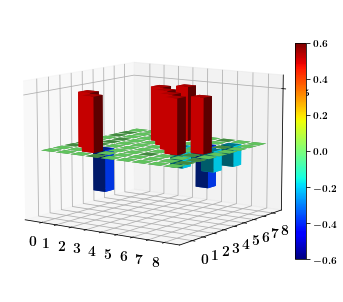

In [24]:
H = Qobj( hamiltonian(1,0.377371),dims= [[3, 3, 3], [3, 3, 3]] )
fig, ax = matrix_histogram(H,limits=[-0.6,0.6])
ax.view_init(azim=-55, elev=10)
plt.show()

In [126]:
# Implementation of two-qubit CZ gate
def CZ_gate(psi,Omega,Delta,tau):
        
    # Times discretization
    times = np.linspace(0.0, tau, 200)
    
    # Apply first pulse
    H = hamiltonian(Omega,Delta)
    result = mesolve(H, psi, times,[], [])
    psi = result.states[-1]
    
    # Apply second pulse rotated by Omega -> Omega exp(i xi)
    H = hamiltonian(Omega * exp_xi(Delta,Omega,tau), Delta)
    result = mesolve(H, psi, times,[], [])
    psi = result.states[-1] 
        
    return psi

# Evolution of the system after the first pulse
def evol_CZ_gate(psi,Omega,Delta,tau,rho_ref):
        
    # Times discretization
    times = np.linspace(0.0, 3*tau, 200)
    
    # Apply first pulse
    H = hamiltonian(Omega,Delta)
    result = mesolve(H, psi, times,[], [rho_ref])
        
    return result

# Chain state initialization
def CZ_init(state_first,state_last):
    
    psi = basis(3,state_first) 
    psi = tensor(psi,basis(3,state_last))
    
    return psi

### Population inversion for system initally in $|11>$: the evolution hamiltonian is $H_2$

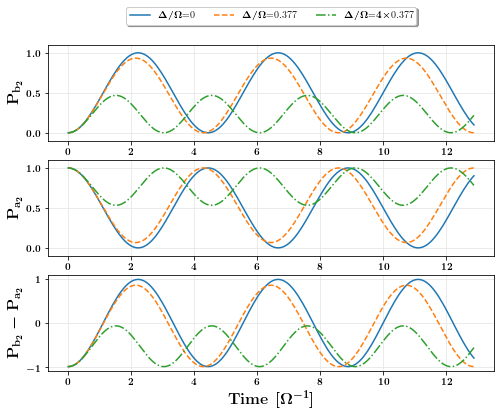

In [26]:
# Fix parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega 
tau = prod_Ot / Omega

# Initialize state
state_first = 1
state_last = 1
psi_init = CZ_init(state_first,state_last) 

Delta_list = [0,frac_DO,4*frac_DO]
pop_b2_list = []
pop_a2_list = []
pop_b2_a2_list = []

for dd in Delta_list:
    
    rho_ref_b2 = ket2dm( np.sqrt(2)/2 * ( CZ_init(2,1) + CZ_init(1,2) ) )
    pop_b2 = evol_CZ_gate(psi_init,Omega,dd,tau,rho_ref_b2)   
    pop_b2_list.append(pop_b2)
    
    rho_ref_a2 = ket2dm( CZ_init(1,1) )
    pop_a2 = evol_CZ_gate(psi_init,Omega,dd,tau,rho_ref_a2)   
    pop_a2_list.append(pop_a2)    

    rho_ref_b2_a2 = rho_ref_b2 - rho_ref_a2
    pop_b2_a2 = evol_CZ_gate(psi_init,Omega,dd,tau,rho_ref_b2_a2 ) 
    pop_b2_a2_list.append(pop_b2_a2)
    
    
fig, ax = plt.subplots(3,1, figsize=(8,6))

ax[0].plot(pop_b2_list[0].times, pop_b2_list[0].expect[0], color=col[0], ls='-', label=r'$\Delta/\Omega$=0')
ax[0].plot(pop_b2_list[1].times, pop_b2_list[1].expect[0], color=col[1], ls='--',label=r'$\Delta/\Omega$=0.377')
ax[0].plot(pop_b2_list[2].times, pop_b2_list[2].expect[0], color=col[2], ls='-.', label=r'$\Delta/\Omega$=$4\times$0.377')
ax[0].set_ylabel(r'$\bf{P_{b_2}}$', fontsize=16)
ax[0].grid(color='0.9')
ax[0].set_ylim(-0.1,1.1)

ax[1].plot(pop_a2_list[0].times, pop_a2_list[0].expect[0], color=col[0], ls='-',  label=r'$\Delta/\Omega$=0')
ax[1].plot(pop_a2_list[1].times, pop_a2_list[1].expect[0], color=col[1], ls='--', label=r'$\Delta/\Omega$=0.377')
ax[1].plot(pop_a2_list[2].times, pop_a2_list[2].expect[0], color=col[2], ls='-.', label=r'$\Delta/\Omega$=$4\times$0.377')
ax[1].set_ylabel(r'$\bf{P_{a_2}}$', fontsize=16)
ax[1].grid(color='0.9')
ax[1].set_ylim(-0.1,1.1)

ax[2].plot(pop_b2_a2_list[0].times, pop_b2_a2_list[0].expect[0], color=col[0], ls='-',  label=r'$\Delta/\Omega$=0')
ax[2].plot(pop_b2_a2_list[1].times, pop_b2_a2_list[1].expect[0], color=col[1], ls='--', label=r'$\Delta/\Omega$=0.377')
ax[2].plot(pop_b2_a2_list[2].times, pop_b2_a2_list[2].expect[0], color=col[2], ls='-.', label=r'$\Delta/\Omega$=$4\times$0.377')
ax[2].set_ylabel(r'$\bf{P_{b_2}-P_{a_2}}$', fontsize=16)
ax[2].grid(color='0.9')
ax[2].set_xlabel(r'\bf{Time} $[\Omega^{-1}]$', fontsize=16);
ax[2].set_ylim(-1.1,1.1)

#ax[3].plot(pop_b2_a2_list[0].times, pop_b2_list[0].expect[0]-pop_a2_list[0].expect[0], label=r'$\Delta/\Omega$=0')
#ax[3].plot(pop_b2_a2_list[1].times, pop_b2_list[1].expect[0]-pop_a2_list[1].expect[0], label=r'$\Delta/\Omega$=0.377')
#ax[3].plot(pop_b2_a2_list[2].times, pop_b2_list[2].expect[0]-pop_a2_list[2].expect[0], label=r'$\Delta/\Omega$=$2\times$0.377')
#ax[3].grid(color='0.9')
#ax[3].set_ylim(-1.1,1.1)

# Put a legend above current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.85),fancybox=True, shadow=True, ncol=3)
plt.savefig("plots/pop_H2.pdf", bbox_inches='tight')
plt.show()

### Population inversion for system initally in $|01>$: the evolution hamiltonian is $H_1$

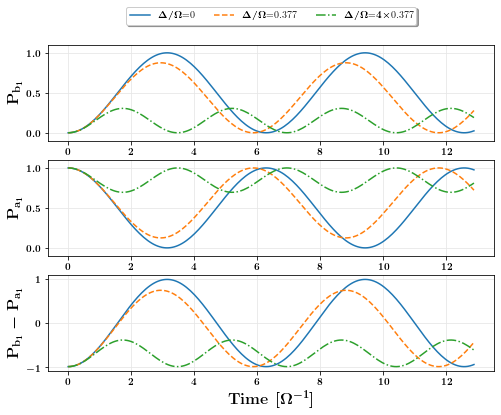

In [27]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega 
tau = prod_Ot / Omega

state_first = 0
state_last = 1
psi_init = CZ_init(state_first,state_last) 

Delta_list = [0,frac_DO,4*frac_DO]
pop_b2_list = []
pop_a2_list = []
pop_b2_a2_list = []

for dd in Delta_list:
    
    rho_ref_b2 = ket2dm( CZ_init(0,2) )
    pop_b2 = evol_CZ_gate(psi_init,Omega,dd,tau,rho_ref_b2)   
    pop_b2_list.append(pop_b2)
    
    rho_ref_a2 = ket2dm( CZ_init(0,1) )
    pop_a2 = evol_CZ_gate(psi_init,Omega,dd,tau,rho_ref_a2)   
    pop_a2_list.append(pop_a2)    

    rho_ref_b2_a2 = rho_ref_b2 - rho_ref_a2
    pop_b2_a2 = evol_CZ_gate(psi_init,Omega,dd,tau,rho_ref_b2_a2 ) 
    pop_b2_a2_list.append(pop_b2_a2)
    
    
fig, ax = plt.subplots(3,1, figsize=(8,6))

ax[0].plot(pop_b2_list[0].times, pop_b2_list[0].expect[0], color=col[0], ls='-', label=r'$\Delta/\Omega$=0')
ax[0].plot(pop_b2_list[1].times, pop_b2_list[1].expect[0], color=col[1], ls='--',label=r'$\Delta/\Omega$=0.377')
ax[0].plot(pop_b2_list[2].times, pop_b2_list[2].expect[0], color=col[2], ls='-.', label=r'$\Delta/\Omega$=$4\times$0.377')
ax[0].set_ylabel(r'$\bf{P_{b_1}}$', fontsize=16)
ax[0].grid(color='0.9')
ax[0].set_ylim(-0.1,1.1)

ax[1].plot(pop_a2_list[0].times, pop_a2_list[0].expect[0], color=col[0], ls='-',  label=r'$\Delta/\Omega$=0')
ax[1].plot(pop_a2_list[1].times, pop_a2_list[1].expect[0], color=col[1], ls='--', label=r'$\Delta/\Omega$=0.377')
ax[1].plot(pop_a2_list[2].times, pop_a2_list[2].expect[0], color=col[2], ls='-.', label=r'$\Delta/\Omega$=$4\times$0.377')
ax[1].set_ylabel(r'$\bf{P_{a_1}}$', fontsize=16)
ax[1].grid(color='0.9')
ax[1].set_ylim(-0.1,1.1)

ax[2].plot(pop_b2_a2_list[0].times, pop_b2_a2_list[0].expect[0], color=col[0], ls='-',  label=r'$\Delta/\Omega$=0')
ax[2].plot(pop_b2_a2_list[1].times, pop_b2_a2_list[1].expect[0], color=col[1], ls='--', label=r'$\Delta/\Omega$=0.377')
ax[2].plot(pop_b2_a2_list[2].times, pop_b2_a2_list[2].expect[0], color=col[2], ls='-.', label=r'$\Delta/\Omega$=$4\times$0.377')
ax[2].set_ylabel(r'$\bf{P_{b_1}-P_{a_1}}$', fontsize=16)
ax[2].grid(color='0.9')
ax[2].set_xlabel(r'\bf{Time} $[\Omega^{-1}]$', fontsize=16);
ax[2].set_ylim(-1.1,1.1)

# Put a legend above current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.85),fancybox=True, shadow=True, ncol=3)
plt.savefig("plots/pop_H1.pdf", bbox_inches='tight')
plt.show()

### Phase plot as a function of $\Delta/\Omega$

In [127]:
# Parameters
frac_DO_list = np.linspace(0,1.7,50)
Omega   = 1
prod_Ot = 4.29268
tau = prod_Ot / Omega

# State |01>

state_first = 0
state_last = 1
psi_init = CZ_init(state_first,state_last) 

phase_01_list = []
phase_diff_list = []

for ff in frac_DO_list:
    
    Delta = ff * Omega
    psi_fin = CZ_gate(psi_init,Omega,Delta,tau) 
    number = np.conj(psi_fin[1][0][0])
    phase_01_list.append( phase_func( number ) )
    phase_diff_list.append( 2*phase_func( number )-np.pi)

phase_01_in_radians = [val*radians for val in phase_01_list] 
phase_diff_in_radians = [val*radians for val in phase_diff_list]     

# State |11>

state_first = 1
state_last = 1
psi_init = CZ_init(state_first,state_last) 

phase_11_list = []

phi_2_list = []

for ff in frac_DO_list:
    
    Delta = ff * Omega 
    psi_fin = CZ_gate(psi_init,Omega,Delta,tau) 
    number = np.conj(psi_fin[4][0][0])
    phase_11_list.append( phase_func( number ) )
    phi_2_list.append( -2*np.pi * Delta / np.sqrt(Delta**2+2*Omega**2)+ 2*np.pi)

phi_2_in_radians = [val*radians for val in phi_2_list]
phase_11_in_radians = [val*radians for val in phase_11_list]

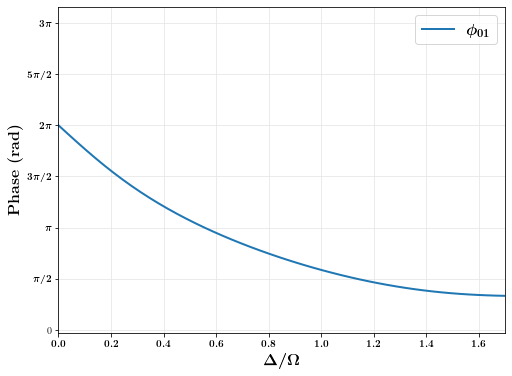

In [128]:
# Plot

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(frac_DO_list, phase_01_in_radians, color=col[0], ls='-', lw='2', yunits=radians, label=r'$\phi_{01}$' )  

ax.set_xlabel(r'$\Delta/\Omega$', fontsize=16);
ax.set_ylabel(r'\bf{Phase (rad)}', fontsize=16)
ax.grid(color='0.9')
ax.set_xlim(0,1.7)
ax.set_ylim(-0.1,3*np.pi+0.5)
plt.legend(fontsize=16)
plt.savefig("plots/phase_01_CZ.pdf", bbox_inches='tight')
plt.show()

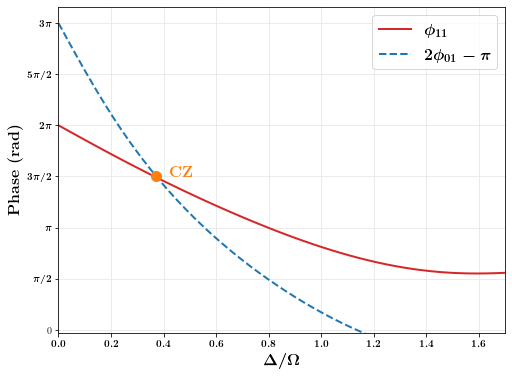

In [129]:
# Plot

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(frac_DO_list, phase_11_in_radians, color=col[3], ls='-', lw='2', yunits=radians, label=r'$\phi_{11}$' ) 
ax.plot(frac_DO_list, phase_diff_in_radians, color=col[0], ls='--', lw='2', yunits=radians, label=r'$2\phi_{01}-\pi$') 
ax.plot(0.37,3*np.pi/2,'.', marker=".", markersize=20, color=col[1])
plt.text(0.42,3*np.pi/2,r'\bf{CZ}',fontsize=16,color=col[1])
#ax.plot(frac_DO_list, phi_2_in_radians, color=col[2], ls='-', lw='2', yunits=radians, label=r'$\phi_2$' ) 

ax.set_xlabel(r'$\Delta/\Omega$', fontsize=16);
ax.set_ylabel(r'\bf{Phase (rad)}', fontsize=16)
ax.grid(color='0.9')
ax.set_xlim(0,1.7)
ax.set_ylim(-0.1,3*np.pi+0.5)
plt.legend(fontsize=16)
plt.savefig("plots/phase_11_CZ.pdf", bbox_inches='tight')
plt.show()

## Imperfect blockade regime

### Functions definition

In [28]:
# Hamiltonian definition for imperfect blockade regime
def hamiltonian_imperfect(Omega,Delta,V):
    
    psi00 = basis(9,0)
    psi01 = basis(9,1) 
    psi0r = basis(9,2)
    psi10 = basis(9,3)
    psi11 = basis(9,4) 
    psi1r = basis(9,5)
    psir0 = basis(9,6)
    psir1 = basis(9,7)
    psirr = basis(9,8)

    H0  = 0 * tensor(psi00.dag(),psi00)
    
    H01 = 1/2 * ( Omega * tensor(psi01.dag(),psi0r) + 
             np.conj(Omega) * tensor(psi0r.dag(),psi01) ) - Delta * tensor(psi0r.dag(),psi0r)
    
    H10 = 1/2 * ( Omega * tensor(psi10.dag(),psir0) + 
             np.conj(Omega) * tensor(psir0.dag(),psi10) ) - Delta * tensor(psir0.dag(),psir0)

    H2  = np.sqrt(2)/2 * ( Omega * ( tensor(psi11.dag(),psir1) + tensor(psi11.dag(),psi1r) + 
                                    tensor(psi1r.dag(),psirr) + tensor(psir1.dag(),psirr) ) 
            + np.conj(Omega) * ( tensor(psir1.dag(),psi11) + tensor(psi1r.dag(),psi11) + 
                                tensor(psirr.dag(),psi1r) + tensor(psirr.dag(),psir1) ) 
            ) - Delta * ( tensor(psir1.dag(),psir1) + tensor(psir1.dag(),psi1r) 
                           + tensor(psi1r.dag(),psir1) + tensor(psi1r.dag(),psi1r)) + (V-2*Delta) * (tensor(psirr.dag(),psirr))

    H = H0 + H01 + H10 + H2
    
    return H

In [29]:
# Implementation of two-qubit CZ gate for imperfect blockade regime
def CZ_gate_imperfect(psi,Omega,Delta,tau,V):
        
    # Times discretization
    times = np.linspace(0.0, tau, 200)
    
    # Apply first pulse
    H = hamiltonian_imperfect(Omega,Delta,V)
    result = mesolve(H, psi, times,[], [])
    psi = result.states[-1]
    
    # Apply second pulse rotated by Omega -> Omega exp(i xi)
    H = hamiltonian_imperfect(Omega * exp_xi(Delta,Omega,tau), Delta, V)
    result = mesolve(H, psi, times,[], [])
    psi = result.states[-1] 
        
    return psi


# Evolution of the system after the first pulse for imperfect blockade regime
def evol_CZ_gate_imperfect(psi,Omega,Delta,tau,V,rho_ref):
        
    # Times discretization
    times = np.linspace(0.0, 3*tau, 200)
    
    # Apply first pulse
    H = hamiltonian_imperfect(Omega,Delta,V)
    result = mesolve(H, psi, times,[], [rho_ref])
        
    return result

### Population for system initally in $|11>$

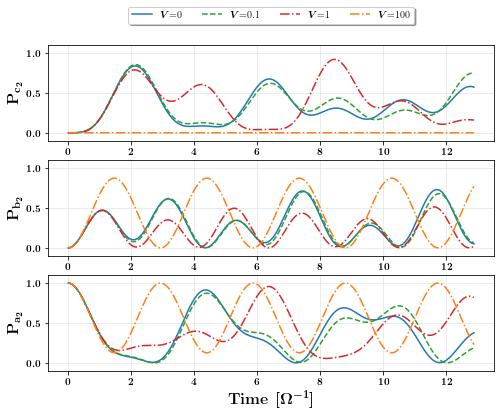

In [30]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega 
tau = prod_Ot / Omega

state_first = 1
state_last = 1
psi_init = CZ_init(state_first,state_last) 

Delta_list = [0,frac_DO,4*frac_DO]
V_list = [0,0.1,1,100]

pop_b2_list = []
pop_a2_list = []
pop_c2_list = []

for vv in V_list:
    
    rho_ref_c2 = ket2dm( CZ_init(2,2) )
    pop_c2 = evol_CZ_gate_imperfect(psi_init,Omega,Delta,tau,vv,rho_ref_c2 ) 
    pop_c2_list.append(pop_c2)
    
    rho_ref_b2 = ket2dm( np.sqrt(2)/2 * ( CZ_init(2,1) + CZ_init(1,2) ) )
    pop_b2 = evol_CZ_gate_imperfect(psi_init,Omega,Delta,tau,vv,rho_ref_b2)   
    pop_b2_list.append(pop_b2)
    
    rho_ref_a2 = ket2dm( CZ_init(1,1) )
    pop_a2 = evol_CZ_gate_imperfect(psi_init,Omega,Delta,tau,vv,rho_ref_a2)   
    pop_a2_list.append(pop_a2)   
    
fig, ax = plt.subplots(3,1, figsize=(8,6))

ax[0].plot(pop_c2_list[0].times, pop_c2_list[0].expect[0], color=col[0], ls='-', label=r'$V$=0')
ax[0].plot(pop_c2_list[1].times, pop_c2_list[1].expect[0], color=col[2], ls='--',label=r'$V$=0.1')
ax[0].plot(pop_c2_list[2].times, pop_c2_list[2].expect[0], color=col[3], ls='-.', label=r'$V$=1')
ax[0].plot(pop_c2_list[3].times, pop_c2_list[3].expect[0], color=col[1], ls='-.', label=r'$V$=100')
ax[0].set_ylabel(r'$\bf{P_{c_2}}$', fontsize=16)
ax[0].grid(color='0.9')
ax[0].set_ylim(-0.1,1.1)

ax[1].plot(pop_b2_list[0].times, pop_b2_list[0].expect[0], color=col[0], ls='-',  label=r'$V$=0')
ax[1].plot(pop_b2_list[1].times, pop_b2_list[1].expect[0], color=col[2], ls='--', label=r'$V$=0.1')
ax[1].plot(pop_b2_list[2].times, pop_b2_list[2].expect[0], color=col[3], ls='-.', label=r'$V$=1')
ax[1].plot(pop_b2_list[3].times, pop_b2_list[3].expect[0], color=col[1], ls='-.', label=r'$V$=100')
ax[1].set_ylabel(r'$\bf{P_{b_2}}$', fontsize=16)
ax[1].grid(color='0.9')
ax[1].set_ylim(-0.1,1.1)

ax[2].plot(pop_a2_list[0].times, pop_a2_list[0].expect[0], color=col[0], ls='-',  label=r'$V$=0')
ax[2].plot(pop_a2_list[1].times, pop_a2_list[1].expect[0], color=col[2], ls='--', label=r'$V$=0.1')
ax[2].plot(pop_a2_list[2].times, pop_a2_list[2].expect[0], color=col[3], ls='-.', label=r'$V$=1')
ax[2].plot(pop_a2_list[3].times, pop_a2_list[3].expect[0], color=col[1], ls='-.', label=r'$V$=100')
ax[2].set_ylabel(r'$\bf{P_{a_2}}$', fontsize=16)
ax[2].grid(color='0.9')
ax[2].set_xlabel(r'\bf{Time} $[\Omega^{-1}]$', fontsize=16);
ax[2].set_ylim(-0.1,1.1)

# Put a legend above current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.85),fancybox=True, shadow=True, ncol=4)
plt.savefig("plots/pop_H2-imp.pdf", bbox_inches='tight')
plt.show()

### Population for system initally in $|01>$

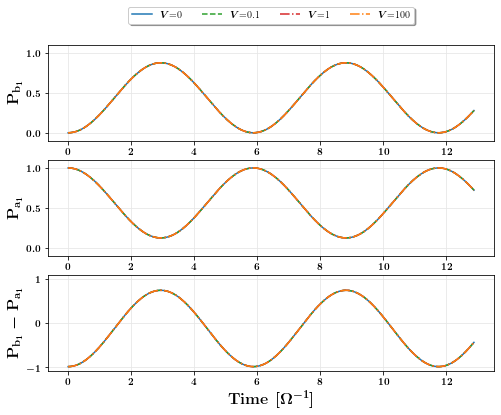

In [31]:
# Parameters
Omega   = 1
frac_DO = 0.377371
prod_Ot = 4.29268
Delta = frac_DO * Omega 
tau = prod_Ot / Omega

state_first = 0
state_last = 1
psi_init = CZ_init(state_first,state_last) 

Delta_list = [0,frac_DO,4*frac_DO]
pop_b2_list = []
pop_a2_list = []
pop_b2_a2_list = []

V_list = [0,0.1,1,100]
 
for vv in V_list:
    rho_ref_b2 = ket2dm( CZ_init(0,2) )
    pop_b2 = evol_CZ_gate_imperfect(psi_init,Omega,Delta,tau,vv,rho_ref_b2)   
    pop_b2_list.append(pop_b2)
    
    rho_ref_a2 = ket2dm( CZ_init(0,1) )
    pop_a2 = evol_CZ_gate_imperfect(psi_init,Omega,Delta,tau,vv,rho_ref_a2)   
    pop_a2_list.append(pop_a2)    

    rho_ref_b2_a2 = rho_ref_b2 - rho_ref_a2
    pop_b2_a2 = evol_CZ_gate_imperfect(psi_init,Omega,Delta,tau,vv,rho_ref_b2_a2 ) 
    pop_b2_a2_list.append(pop_b2_a2)
    
    
fig, ax = plt.subplots(3,1, figsize=(8,6))

ax[0].plot(pop_b2_list[0].times, pop_b2_list[0].expect[0], color=col[0], ls='-', label=r'$V$=0')
ax[0].plot(pop_b2_list[1].times, pop_b2_list[1].expect[0], color=col[2], ls='--',label=r'$V$=0.1')
ax[0].plot(pop_b2_list[2].times, pop_b2_list[2].expect[0], color=col[3], ls='-.',label=r'$V$=1')
ax[0].plot(pop_b2_list[3].times, pop_b2_list[3].expect[0], color=col[1], ls='-.',label=r'$V$=100')
ax[0].set_ylabel(r'$\bf{P_{b_1}}$', fontsize=16)
ax[0].grid(color='0.9')
ax[0].set_ylim(-0.1,1.1)

ax[1].plot(pop_a2_list[0].times, pop_a2_list[0].expect[0], color=col[0], ls='-',  label=r'$V$=0')
ax[1].plot(pop_a2_list[1].times, pop_a2_list[1].expect[0], color=col[2], ls='--', label=r'$V$=0.1')
ax[1].plot(pop_a2_list[2].times, pop_a2_list[2].expect[0], color=col[3], ls='-.', label=r'$V$=1')
ax[1].plot(pop_a2_list[3].times, pop_a2_list[3].expect[0], color=col[1], ls='-.', label=r'$V$=100')
ax[1].set_ylabel(r'$\bf{P_{a_1}}$', fontsize=16)
ax[1].grid(color='0.9')
ax[1].set_ylim(-0.1,1.1)

ax[2].plot(pop_b2_a2_list[0].times, pop_b2_a2_list[0].expect[0], color=col[0], ls='-',  label=r'$V$=0')
ax[2].plot(pop_b2_a2_list[1].times, pop_b2_a2_list[1].expect[0], color=col[2], ls='--', label=r'$V$=0.1')
ax[2].plot(pop_b2_a2_list[2].times, pop_b2_a2_list[2].expect[0], color=col[3], ls='-.', label=r'$V$=1')
ax[2].plot(pop_b2_a2_list[3].times, pop_b2_a2_list[3].expect[0], color=col[1], ls='-.', label=r'$V$=100')
ax[2].set_ylabel(r'$\bf{P_{b_1}-P_{a_1}}$', fontsize=16)
ax[2].grid(color='0.9')
ax[2].set_xlabel(r'\bf{Time} $[\Omega^{-1}]$', fontsize=16);
ax[2].set_ylim(-1.1,1.1)

# Put a legend above current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.85),fancybox=True, shadow=True, ncol=4)
plt.savefig("plots/pop_H1-imp.pdf", bbox_inches='tight')
plt.show()

### Phase plot as a function of $\Delta/\Omega$

In [136]:
# Parameters
frac_DO_list = np.linspace(0,1.7,50)
Omega   = 1
prod_Ot = 4.29268
tau = prod_Ot / Omega
V = 1

# State |01>

state_first = 0
state_last = 1
psi_init = CZ_init(state_first,state_last) 

phase_01_list = []
phase_diff_list = []

for ff in frac_DO_list:
    
    Delta = ff * Omega
    psi_fin = CZ_gate_imperfect(psi_init,Omega,Delta,tau,V) 
    number = np.conj(psi_fin[1][0][0])
    phase_01_list.append( phase_func( number ) )
    phase_diff_list.append( 2*phase_func( number )-np.pi)

phase_01_in_radians = [val*radians for val in phase_01_list] 
phase_diff_in_radians = [val*radians for val in phase_diff_list]     

# State |11>
V = 1

state_first = 1
state_last = 1
psi_init = CZ_init(state_first,state_last) 

phase_11_list = []

for ff in frac_DO_list:
    
    Delta = ff * Omega #* (Omega**2/(2*V))
    psi_fin = CZ_gate_imperfect(psi_init,Omega,Delta,tau,V) 
    number = np.conj(psi_fin[4][0][0])
    phase_11_list.append( phase_func( number ) )

print(phase_11_list)
phase_11_in_radians = [val*radians for val in phase_11_list]

[3.0089818317375663, 2.7124605993503725, 2.4415371673120956, 2.200768295018551, 1.9873402442021284, 1.788197906010982, 1.5843842080401243, 1.3608571723389957, 1.1120434274658546, 0.8399034982312396, 0.5496268825770231, 0.24677973876947198, 6.219358097599738, 5.904816662556529, 5.58926088764409, 5.274859631222126, 4.963114335430108, 4.6549640435010895, 4.350830529718364, 4.050593131339981, 3.7535000237866476, 3.4579223988902106, 3.160779095497463, 2.8561177797998307, 2.5313003233335354, 2.155034583505895, 1.633321676636601, 0.7157895236153065, 5.948575317836044, 5.353950036667297, 4.977904849831452, 4.6850925921368525, 4.432546312038887, 4.204139050853585, 3.992813728577068, 3.7952087619797137, 3.609720529142963, 3.435697676530068, 3.2730646992335415, 3.1221247221368538, 2.9834405770511587, 2.8577470276007877, 2.745867339275395, 2.6486149235636582, 2.56666359710642, 2.5003744265447336, 2.449580273340653, 2.4133660603748157, 2.3899148405851065, 2.376500762046443]


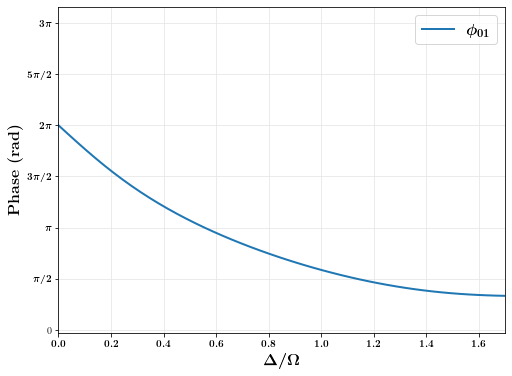

In [137]:
# Plot

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(frac_DO_list, phase_01_in_radians, color=col[0], ls='-', lw='2', yunits=radians, label=r'$\phi_{01}$' )  

ax.set_xlabel(r'$\Delta/\Omega$', fontsize=16);
ax.set_ylabel(r'\bf{Phase (rad)}', fontsize=16)
ax.grid(color='0.9')
ax.set_xlim(0,1.7)
ax.set_ylim(-0.1,3*np.pi+0.5)
plt.legend(fontsize=16)
#plt.savefig("plots/phase_01_CZ_imp.pdf", bbox_inches='tight')
plt.show()

In [139]:
plus_two_pi = [3.0089818317375663, 2.7124605993503725, 2.4415371673120956, 2.200768295018551, 1.9873402442021284, 
 1.788197906010982, 1.5843842080401243, 1.3608571723389957, 1.1120434274658546, 0.8399034982312396, 
 0.5496268825770231, 0.24677973876947198]

zero_pi = [6.219358097599738, 5.904816662556529, 5.58926088764409, 5.274859631222126, 4.963114335430108, 4.6549640435010895, 
 4.350830529718364, 4.050593131339981, 3.7535000237866476, 3.4579223988902106, 3.160779095497463, 
 2.8561177797998307, 2.5313003233335354, 2.155034583505895, 1.633321676636601, 0.7157895236153065]
 
minus_two_pi = [5.948575317836044, 5.353950036667297, 4.977904849831452, 4.6850925921368525, 4.432546312038887, 
 4.204139050853585, 3.992813728577068, 3.7952087619797137, 3.609720529142963, 3.435697676530068, 
 3.2730646992335415, 3.1221247221368538, 2.9834405770511587, 2.8577470276007877, 2.745867339275395, 
 2.6486149235636582, 2.56666359710642, 2.5003744265447336, 2.449580273340653, 2.4133660603748157, 
 2.3899148405851065, 2.376500762046443]


plus_two_pi = [ i + 2*np.pi for i in plus_two_pi ]
minus_two_pi = [ i - 2*np.pi for i in minus_two_pi ]

phase_11_list = plus_two_pi + zero_pi + minus_two_pi
phase_11_in_radians = [val*radians for val in phase_11_list]

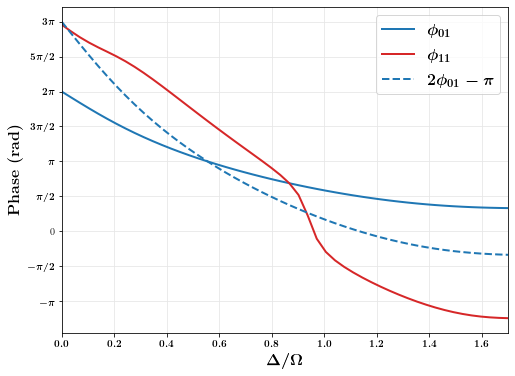

In [142]:
# Plot

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(frac_DO_list, phase_01_in_radians, color=col[0], ls='-', lw='2', yunits=radians, label=r'$\phi_{01}$' ) 
ax.plot(frac_DO_list, phase_11_in_radians, color=col[3], lw='2', markersize=10, yunits=radians, label=r'$\phi_{11}$' )  
ax.plot(frac_DO_list, phase_diff_in_radians, color=col[0], ls='--', lw='2', yunits=radians, label=r'$2\phi_{01}-\pi$') 


#ax.plot(0.37,3*np.pi/2,'.', marker=".", markersize=20, color=col[2])
#plt.text(0.42,3*np.pi/2,r'\bf{CZ}',fontsize=16,color=col[2])

ax.set_xlabel(r'$\Delta/\Omega$', fontsize=16);
ax.set_ylabel(r'\bf{Phase (rad)}', fontsize=16)
ax.grid(color='0.9')
ax.set_xlim(0,1.7)
#ax.set_ylim(-0.1,3*np.pi+0.5)
plt.legend(fontsize=16)
plt.savefig("plots/phase_11_01_CZ_imp.pdf", bbox_inches='tight')
plt.show()